In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#importing dependencies related to image transformations
import torchvision
from torchvision import transforms
from PIL import Image

#importing dependencies related to data loading
from torchvision import datasets
from torch.utils.data import DataLoader

#importing Tensorboard for data visualization
from torch.utils.tensorboard import SummaryWriter


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
data = {
    'train':
    datasets.ImageFolder(root='/content/gdrive/MyDrive/Face Mask Dataset/Train', transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root='/content/gdrive/MyDrive/Face Mask Dataset/Test', transform=image_transforms['test']),
}

# Dataloader iterators, used for making batches
dataloaders = {
    'train': DataLoader(data['train'], batch_size=64, shuffle=True),
    'test': DataLoader(data['test'], batch_size=8, shuffle=False)
}

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
!nvidia-smi

Mon May  3 03:29:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier[1] = nn.Sequential(
                      nn.Linear(1280, 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(32, 2), 
                      nn.LogSoftmax(dim=1))

In [ ]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

830498


In [ ]:
if torch.cuda.is_available():
    print('training on GPU')
    device = torch.device("cuda:0")
else:
    print('training on CPU')
    device = torch.device("cpu")


training on GPU


In [ ]:
from tqdm.notebook import tqdm #for loading bars
train_loss = []
test_loss = []
train_loader=dataloaders['train']
val_loader = dataloaders['test']
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


for epoch in tqdm(range(epochs)):
  training_loss = 0.0
  valid_loss = 0.0
  model.train().to(device)
  for batch in train_loader:
    optimizer.zero_grad()
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    output = model(inputs).to(device)
    loss = criterion(output, targets).to(device)
    loss.backward()
    optimizer.step()
    training_loss += loss.data.item() * inputs.size(0)
  training_loss /= len(train_loader.dataset)
        
  model.eval().to(device)
  num_correct = 0 
  num_examples = 0
  for batch in (val_loader):
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = criterion(output,targets) 
    valid_loss += loss.data.item() * inputs.size(0)          
    correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
  valid_loss /= len(val_loader.dataset)

  train_loss.append(training_loss)
  test_loss.append(valid_loss)

  print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,valid_loss, num_correct / num_examples))
        
        #save model
  if(training_loss<0.005):
      torch.save(model,"saves/"+str(epoch)+".pth")
        


Epoch: 0, Training Loss: 0.1465, Validation Loss: 0.0765, accuracy = 0.9738
Epoch: 1, Training Loss: 0.0418, Validation Loss: 0.0248, accuracy = 0.9899
Epoch: 2, Training Loss: 0.0477, Validation Loss: 0.0607, accuracy = 0.9768
Epoch: 3, Training Loss: 0.0417, Validation Loss: 0.0125, accuracy = 0.9940
Epoch: 4, Training Loss: 0.0274, Validation Loss: 0.0112, accuracy = 0.9960
Epoch: 5, Training Loss: 0.0366, Validation Loss: 0.0118, accuracy = 0.9940
Epoch: 6, Training Loss: 0.0324, Validation Loss: 0.0109, accuracy = 0.9940
Epoch: 7, Training Loss: 0.0318, Validation Loss: 0.0304, accuracy = 0.9899
Epoch: 8, Training Loss: 0.0334, Validation Loss: 0.0126, accuracy = 0.9950
Epoch: 9, Training Loss: 0.0327, Validation Loss: 0.0107, accuracy = 0.9940
Epoch: 10, Training Loss: 0.0245, Validation Loss: 0.0176, accuracy = 0.9950
Epoch: 11, Training Loss: 0.0276, Validation Loss: 0.0119, accuracy = 0.9940
Epoch: 12, Training Loss: 0.0240, Validation Loss: 0.0124, accuracy = 0.9960
Epoch: 13

In [ ]:
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [ ]:
torch.save(model, "./trained_model.pt")
model_save_name = 'model_f.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
test_model(model)

correct: 989  total: 992
accuracy = 0.996976


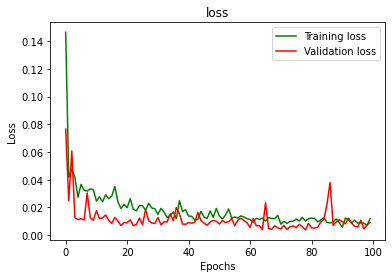

In [ ]:
import matplotlib.pyplot as plt

epochs = range(0,len(train_loss))
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Validation loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Testing


In [ ]:
prototxt_path = '/content/deploy.prototxt'
faceDetect_path = '/content/faceDetect.caffemodel'

In [ ]:
import cv2
print("loading models")
maskDetectModel = torch.load("/content/trained_model.pth")
maskDetectModel.eval()
faceDetectModel = cv2.dnn.readNetFromCaffe(prototxt_path, faceDetect_path)

loading models


In [ ]:
def detect_face(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    faceDetectModel.setInput(blob)
    detections = faceDetectModel.forward()
    faces=[]
    positions=[]
    for i in range(0, detections.shape[2]):
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX,startY)=(max(0,startX-15),max(0,startY-15))
        (endX,endY)=(min(w-1,endX+15),min(h-1,endY+15))
        confidence = detections[0, 0, i, 2]
        # If confidence > 0.5, show box around face
        if (confidence > 0.3):
            face = frame[startY:endY, startX:endX]
            faces.append(face)
            positions.append((startX,startY,endX,endY))
    return faces,positions


In [ ]:
def detect_mask(faces):
    predictions = []
    image_transforms = transforms.Compose([transforms.Resize(size=(244,244)), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    if (len(faces)>0):
        for img in faces:
            img = Image.fromarray(img)
            img = image_transforms(img).to(device)
            img = img.unsqueeze(0).to(device)
            prediction = maskDetectModel(img).to(device)
            prediction = prediction.argmax().to(device)
            predictions.append(prediction.data)
    return predictions

In [ ]:
cap = cv2.VideoCapture("/content/IMG_5105.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output.mp4",fourcc, 30,(1920,1080))

In [ ]:
import numpy as np

  #ret, frame = cap.read()
frame = cv2.imread("/content/2559.jpg")
(faces,postions) = detect_face(frame)


predictions=detect_mask(faces)
    
for(box,prediction) in zip(postions,predictions):
  (startX, startY, endX, endY) = box
  label = "Mask" if prediction == 0 else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (255,0,0)
  cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(frame,(startX, startY),(endX, endY),color,2)
    # Display the resulting frame
cv2.imwrite('frame.png',frame)
  #out.write(frame)


True